RUN SBI-SGM in cohort for each band

parameters order is  :taue,taui,tauG,speed,alpha,gii,gei (In second)


## Import some pkgs

In [29]:
import sys
sys.path.append("../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict

plt.rcParams["savefig.bbox"] = "tight"

In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [33]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

## Some fns

In [4]:
def _simulate_data(raw_params, brain, prior_bds, freqrange):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tau_e"] =  params[0].item()
    params_dict["tau_i"] =  params[1].item()
    params_dict["tauC"] =  params[2].item()
    params_dict["speed"] =  params[3].item()
    params_dict["alpha"] =  params[4].item()
    params_dict["gii"] =  params[5].item()
    params_dict["gei"] =  params[6].item()
    modelFC = build_fc_freq_m(brain , params_dict, freqrange)
    return np.abs(modelFC[:68, :68])

In [5]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

In [6]:
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [7]:
# paras to model FC via sgm
def _paras_2FC(raw_params, brain, prior_bds, freqrange):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tau_e"] =  params[0].item()
    params_dict["tau_i"] =  params[1].item()
    params_dict["tauC"] =  params[2].item()
    params_dict["speed"] =  params[3].item()
    params_dict["alpha"] =  params[4].item()
    params_dict["gii"] =  params[5].item()
    params_dict["gei"] =  params[6].item()
    modelFC = build_fc_freq_m(brain , params_dict, freqrange)
    return modelFC[:68, :68]
    
#taue,taui,tauG,speed,alpha,gii,gei

In [8]:
def get_mode(x):
    kde_est = scipy.stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), 500)
    ys = kde_est(xs)
    return xs[np.argmax(ys)]

### Some parameters

In [9]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta = [13, 20]
_paras.beta_l = [13, 20]

In [10]:
# Parameter bounds for optimization
v_lower = 3.5-1.8
v_upper = 3.5+1.8
bnds = ((0.005,0.030), (0.005,0.2), (0.005,0.030), (v_lower,v_upper), (0.1,1.0), (0.5,10.0), (0.5,10.0))
#taue,taui,tauG,speed,alpha,gii,gei

In [60]:
paras = edict()

paras.fc_type = "beta_l" #stick to coh
paras.freqrange =  np.linspace(_paras[paras.fc_type][0], _paras[paras.fc_type][1], 5)
print(paras.freqrange)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
paras.par_low =  np.array([ix[0] for ix in bnds])
paras.par_high = np.array([ix[1] for ix in bnds])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.05

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(1e3)
paras.SBI_paras.density_model = "nsf"
paras.SBI_paras.num_round = 3
paras.SBI_paras.noise_sd = 0.20
paras.SBI_paras.save_fil =  f"posteriorMRmul_{paras.fc_type}_" + \
                            f"num{paras.SBI_paras.num_prior_sps}_" + \
                            f"density{paras.SBI_paras.density_model}_" + \
                            f"MR{paras.SBI_paras.num_round}_" + \
                            f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_" +\
                            f"addv{paras.add_v*100:.0f}_ind_cohort.pkl"
print(paras.SBI_paras.save_fil, (RES_ROOT/paras.SBI_paras.save_fil).exists())

[13.   14.75 16.5  18.25 20.  ]
posteriorMRmul_beta_l_num1000_densitynsf_MR3_noise_sd20_addv5_ind_cohort.pkl True


In [61]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

In [62]:
prior = MultivariateNormal(loc=torch.zeros(7), covariance_matrix=torch.eye(7)*(paras.prior_sd**2))

### Load the data

In [63]:
# SC
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.max(cur_ind_conn)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], cur_ind_conn[:34, 34:68] + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], cur_ind_conn[34:68, :34] + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], cur_ind_conn[68:77, 77:] + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], cur_ind_conn[77:, 68:77] + add_v)
    return cur_ind_conn


if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))
ind_conn_cohort = ind_conn.mean(axis=-1)

Add 0.05 on diag


In [64]:
# Load true MEG FC time series:
dataPath = DATA_ROOT/f'./MEG_FC_{paras.fc_type}_DK_networks_coh.mat'
data = loadmat(dataPath);
true_FC = data[f"MEG_{paras.fc_type}_FC_networks_coh"]
true_FC_cohort = true_FC.mean(axis=-1)

## Analyze the results for single data

### Point estimation

In [65]:
cur_posterior = load_pkl(RES_ROOT/paras.SBI_paras.save_fil)
post_sps = cur_posterior.sample((10000, ))

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC1/SBI-SGM-FC/notebooks/../mypkg/../results/posteriorMRmul_beta_l_num1000_densitynsf_MR3_noise_sd20_addv5_ind_cohort.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [66]:
cur_est_paras = torch.median(post_sps, axis=0)[0]
    
# get the cur brain
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn_cohort
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
    
cur_obs_FC = np.abs(true_FC_cohort)
cur_est_FC = np.abs(_paras_2FC(cur_est_paras, 
                               brain=brain, 
                               prior_bds=paras.prior_bds, 
                               freqrange=paras.freqrange))
est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]

<AxesSubplot:title={'center':'SC'}>

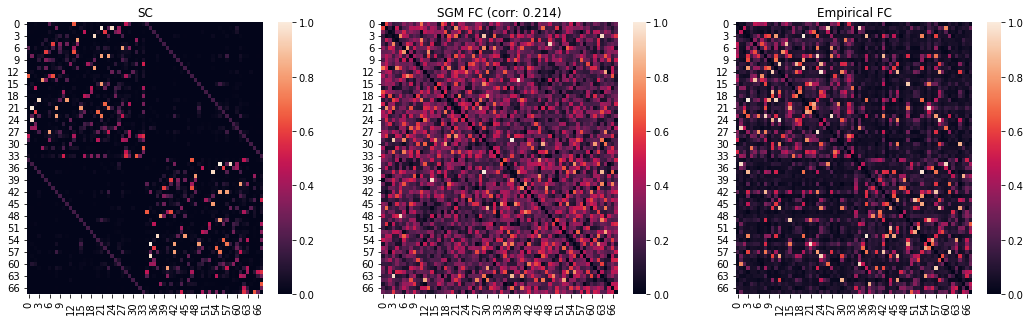

In [67]:
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(est_vec)
obs_FC_mm = _vec_2mat(obs_vec)
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

### Full Bayesian

In [68]:
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.connectome =  ind_conn_cohort
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

_simulate_data_sp = partial(_simulate_data, 
                            brain=brain, 
                            prior_bds=paras.prior_bds, 
                            freqrange=paras.freqrange)
_simulate_data_wrapper, _ = prepare_for_sbi(_simulate_data_sp, prior)

In [69]:
cur_posterior = load_pkl(RES_ROOT/paras.SBI_paras.save_fil)

_, cur_post_psds = simulate_for_sbi(_simulate_data_wrapper, cur_posterior,
                                    num_simulations=1000, 
                                    num_workers=20)
cur_post_psds = cur_post_psds.reshape(-1, 68, 68)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC1/SBI-SGM-FC/notebooks/../mypkg/../results/posteriorMRmul_beta_l_num1000_densitynsf_MR3_noise_sd20_addv5_ind_cohort.pkl


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [70]:
cur_obs_FC = np.abs(true_FC_cohort)
cur_est_FC = np.abs(cur_post_psds.mean(axis=0).numpy())
est_vec = _minmax_vec(cur_est_FC[np.triu_indices(68, k = 1)])
obs_vec = _minmax_vec(cur_obs_FC[np.triu_indices(68, k = 1)])
corr = scipy.stats.pearsonr(est_vec, obs_vec)[0]

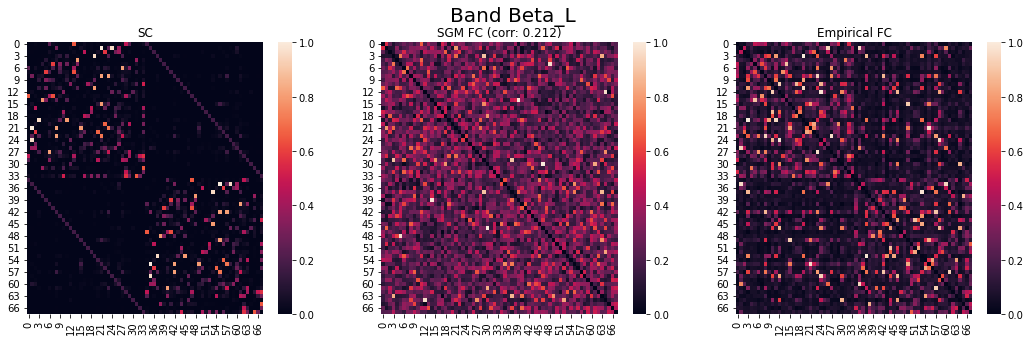

In [71]:
SC = brain.connectome[:68, :68]
SC_vec = _minmax_vec(SC[np.triu_indices(68, k = 1)])
est_FC_mm = _vec_2mat(est_vec)
obs_FC_mm = _vec_2mat(obs_vec)
SC_mm = _vec_2mat(SC_vec)

plt.figure(figsize=[18, 5])
plt.suptitle(f"Band {paras.fc_type.title()}", fontsize=20)
plt.subplot(132)
plt.title(f"SGM FC (corr: {corr:.3f})")
sns.heatmap(est_FC_mm)
plt.subplot(133)
plt.title("Empirical FC")
sns.heatmap(obs_FC_mm)
#sns.heatmap(cur_obs_FC)
plt.subplot(131)
plt.title("SC")
sns.heatmap(SC_mm)

plt.savefig(FIG_ROOT/f"Cohort_level_FC_bandwise_{paras.fc_type}.jpg")